## Feature R&D

[Last time,](DEN1_datasim.ipynb) we loaded data, saw that it was basically usable for simulation and then stored it.  

Now, we look a bit closer at the data and look at how to best use it given the off-the-shelf tensor flow tools we'll try to apply.


In [1]:
# imports
import collections
import pandas as pd
import numpy as np
from scipy import stats

import sklearn
from sklearn import preprocessing as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
import sys
import tensorflow as tf
import time
import os
import os.path
import pickle
import logging as log
log.basicConfig(level=log.DEBUG)


In [2]:
f = 'U.pkl'
P = pickle.load(open(f))
log.info('loaded <%s>',f)
P.describe()


INFO:root:loaded <U.pkl>


,Multiplier,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD,Fwd_Open,Fwd_COReturn
count,2725932.0,2.725932e+06,2.725932e+06,2.725932e+06,2.725932e+06,2.725932e+06,2.725931e+06,2.725931e+06,2.725931e+06,2.725932e+06,2.725932e+06,2.725929e+06,2.725932e+06,2.725932e+06
mean,1.0,2.226893e+02,2.243057e+02,2.208029e+02,2.226456e+02,4.025552e+06,4.023279e+06,2.661003e-04,2.940238e-04,2.227142e+02,2.940263e-04,2.206396e-02,2.227574e+02,3.153228e-04
std,0.0,5.015723e+03,5.042574e+03,4.979409e+03,5.012831e+03,1.212138e+07,1.086728e+07,4.786192e-01,2.754559e-02,5.014403e+03,2.754558e-02,1.668339e-02,5.017295e+03,1.402322e-02
min,1.0,1.455814e-02,7.864865e-02,1.455814e-02,5.898649e-02,4.300000e+01,1.000000e+02,-9.486203e+00,-3.570812e+00,5.898649e-02,-3.570812e+00,0.000000e+00,1.455814e-02,-9.997442e-01
25%,1.0,1.536626e+01,1.560987e+01,1.511146e+01,1.536896e+01,6.116000e+05,6.956722e+05,-2.777810e-01,-1.029169e-02,1.537259e+01,-1.029169e-02,1.215633e-02,1.537000e+01,-3.631412e-03
50%,1.0,2.655789e+01,2.693000e+01,2.617679e+01,2.656049e+01,1.462800e+06,1.580758e+06,-1.145079e-02,2.200946e-04,2.656879e+01,2.200946e-04,1.756784e-02,2.656501e+01,0.000000e+00
75%,1.0,4.509414e+01,4.563840e+01,4.454000e+01,4.510266e+01,3.598300e+06,3.713368e+06,2.617968e-01,1.102714e-02,4.511558e+01,1.102714e-02,2.636890e-02,4.510598e+01,4.241282e-03
max,1.0,2.281800e+05,2.293740e+05,2.275300e+05,2.293000e+05,2.304019e+09,6.079510e+08,1.032482e+01,1.449269e+00,2.293000e+05,1.449269e+00,8.122759e-01,2.281800e+05,3.078370e+00


INFO:root:ran over 4246 days and 2725932 rows in 149 secs


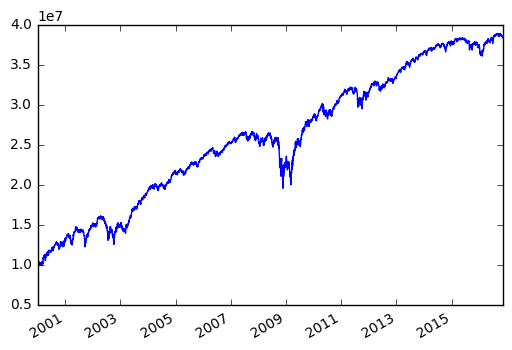

In [3]:
import sim
# can we still sim?

_,B = sim.sim(P)
# plot NAV
B.NAV.plot()


In [4]:
P.head()

,Sym,Product,Instrument,Multiplier,Expiry,Strike,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD,Fwd_Open,Fwd_COReturn
Date,,,,,,,,,,,,,,,,,,,
2000-01-03,A,A,STK,1.0,None,None,75.056373,75.237461,64.219662,68.622969,3343600.0,NaN,NaN,NaN,63.380937,-0.079464,NaN,64.934485,-0.053750
2000-01-03,GRA,GRA,STK,1.0,None,None,13.879021,13.879021,12.883395,13.192039,336400.0,4419093.25,-0.468448,0.005059,13.062608,-0.009860,0.016753,13.062608,-0.009811
2000-01-03,EXP,EXP,STK,1.0,None,None,10.710783,10.710783,10.040672,10.128556,65400.0,4430764.95,0.029394,-0.002749,9.822796,-0.030653,0.011283,10.097559,-0.003060
2000-01-03,KSU,KSU,STK,1.0,None,None,9.095807,9.103232,8.670098,8.724549,1258900.0,2923306.65,-0.143287,0.003041,8.276565,-0.052713,0.013133,8.538921,-0.021277
2000-01-03,TIVO,TIVO,STK,1.0,None,None,35.690000,36.120000,33.250000,34.810000,334200.0,970605.65,-0.277089,0.012279,31.500000,-0.099917,0.007765,32.500000,-0.066360


Looks like it did yesterday.

Ok, now we want to use some portion of this data to train simple ml models.  

Let's define and run a function to normalize the data.


In [5]:
def prep_ml( u, show_plots=False  ) :
    # given universe, prep for ML: scale, center & generate moments
    t0 = time.time()
    log.info('scaling & centering...')

    u.reset_index( inplace=True)
    u.sort_values(['Sym','Date'],inplace=True)
    u.Date = pd.to_datetime(u.Date)
    u.set_index('Date',inplace=True)

    # scale & center prices & volume
    raw_scaled = u.groupby('Sym').transform( lambda x : (x - x.mean())/x.std())
    u = pd.concat([ u.Sym, raw_scaled], axis=1)

    # graphical sanity check
    if (show_plots):
        log.info('Plotting scaled & centered prices')
        fig, ax = plt.subplots()
        u.groupby('Sym')['Close'].plot(ax=ax)

    log.info('completed scaling & centering in %d...',(time.time()-t0))

    return u


INFO:root:scaling & centering...
INFO:root:Plotting scaled & centered prices
INFO:root:completed scaling & centering in 89...


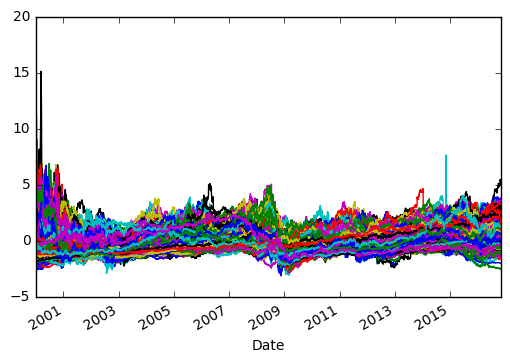

In [6]:
Z = prep_ml(P,show_plots=True)

In [7]:
Z.head()


,Sym,Multiplier,Expiry,Strike,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD,Fwd_Open,Fwd_COReturn
Date,,,,,,,,,,,,,,,,,
2000-01-03,A,NaN,NaN,NaN,2.862034,2.745488,2.199969,2.399050,0.247271,NaN,NaN,NaN,2.027244,-2.736256,NaN,2.142453,-3.572137
2000-01-04,A,NaN,NaN,NaN,2.139957,2.083116,2.015166,2.025568,0.285454,0.448959,0.046118,-2.735898,1.691579,-2.657837,NaN,2.014510,-0.218254
2000-01-05,A,NaN,NaN,NaN,2.012131,1.913902,1.773446,1.690113,0.703581,0.483766,0.452282,-2.657486,1.585579,-0.881518,NaN,1.700097,0.110254
2000-01-06,A,NaN,NaN,NaN,1.698007,1.630122,1.549995,1.584179,-0.653288,0.749477,-1.958789,-0.881320,1.925321,2.763058,-1.437352,1.525196,-1.017116
2000-01-07,A,NaN,NaN,NaN,1.523267,1.889540,1.611128,1.923709,-0.533268,0.263876,0.254758,2.762944,2.193038,2.032374,0.378162,2.201661,4.162598


Let's clean-out uninteresting columns

In [8]:
print Z.shape
Z.drop(['Multiplier','Expiry','Strike', 'Fwd_Open', 'Fwd_COReturn'],axis=1, inplace=True)
print Z.shape
Z.head()

(2725932, 17)
(2725932, 12)


,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD
Date,,,,,,,,,,,,
2000-01-03,A,2.862034,2.745488,2.199969,2.399050,0.247271,NaN,NaN,NaN,2.027244,-2.736256,NaN
2000-01-04,A,2.139957,2.083116,2.015166,2.025568,0.285454,0.448959,0.046118,-2.735898,1.691579,-2.657837,NaN
2000-01-05,A,2.012131,1.913902,1.773446,1.690113,0.703581,0.483766,0.452282,-2.657486,1.585579,-0.881518,NaN
2000-01-06,A,1.698007,1.630122,1.549995,1.584179,-0.653288,0.749477,-1.958789,-0.881320,1.925321,2.763058,-1.437352
2000-01-07,A,1.523267,1.889540,1.611128,1.923709,-0.533268,0.263876,0.254758,2.762944,2.193038,2.032374,0.378162


In [9]:
# let's get rid of NaNs from rolling windows
K = Z.dropna()
K.shape
K.head()

,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD
Date,,,,,,,,,,,,
2000-01-06,A,1.698007,1.630122,1.549995,1.584179,-0.653288,0.749477,-1.958789,-0.881320,1.925321,2.763058,-1.437352
2000-01-07,A,1.523267,1.889540,1.611128,1.923709,-0.533268,0.263876,0.254758,2.762944,2.193038,2.032374,0.378162
2000-01-10,A,2.199110,2.132498,2.212618,2.191258,-0.815726,0.016278,-0.648675,2.032322,2.129166,-0.469901,3.165341
2000-01-11,A,2.195030,2.087067,2.133918,2.127426,-0.938805,-0.234615,-0.349046,-0.469738,2.036077,-0.698274,3.178702
2000-01-12,A,2.131118,2.025175,1.966681,2.034395,-1.118129,-0.445882,-0.622346,-0.698092,2.104026,0.517023,2.682668


### data

The data is currently tainted with a few forward-looking values, all tagged Fwd_* they will need to be excised from the training set and perhaps used to create the 'labels' for classification purposes.  The data breaks down:

 - prices & moments: open, high, low, close; return, 20-day SD
 - volume, deltaV, 20-day ADV
 
Including the open, high, & low prices seem a bit heavy to me - a lot of parameters for limited information.  Perhaps we can represent them better.  One type of information we might hope to glean from them is the localized volatility.  This could be usefully transformed using Garman-Klass or something similar:

$$ \sigma = \sqrt{ \frac{Z}{n} \sum
  \left[ \textstyle\frac{1}{2}\displaystyle
    \left( \log \frac{H_i}{L_i} \right)^2  - (2\log 2-1)
    \left( \log \frac{C_i}{O_i} \right)^2 \right] }. $$

Z = Number of closing prices in a year, n = number of historical prices used for the volatility estimate.

For now, let's use the data as-is to establish a baseline and then see what else we can do.

###  model 
Let's start simple with a linear model as baseline and then see if an off-the-shelf DNN says anything (more) interesting. 

###  classes 
What classifications will we create?  

Let's see if the data advises otherwise, but it seems that we could break the universe of returns into three segments: 

 0. down 
 1. flat 
 2. up

So, let's figure out what values should partition the classes and then convert our fwd-looking return to the labels and get rid of the fwd-looking values entirely.


[-0.25933068  0.26670854]


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/p

Label
0    908662
1    908554
2    908713
dtype: int64


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,SD,DOY,DOW,FSYM,VARATIO,Label
Date,,,,,,,,,,,,,,,
2000-01-06,A,1.698007,1.630122,1.549995,1.584179,-0.653288,0.749477,-1.958789,-0.881320,1.437352,6,3,0,0.871659,2
2000-01-07,A,1.523267,1.889540,1.611128,1.923709,-0.533268,0.263876,0.254758,2.762944,0.378162,7,4,0,2.020908,2
2000-01-10,A,2.199110,2.132498,2.212618,2.191258,-0.815726,0.016278,-0.648675,2.032322,3.165341,10,0,0,50.110806,0
2000-01-11,A,2.195030,2.087067,2.133918,2.127426,-0.938805,-0.234615,-0.349046,-0.469738,3.178702,11,1,0,4.001468,0
2000-01-12,A,2.131118,2.025175,1.966681,2.034395,-1.118129,-0.445882,-0.622346,-0.698092,2.682668,12,2,0,2.507681,2


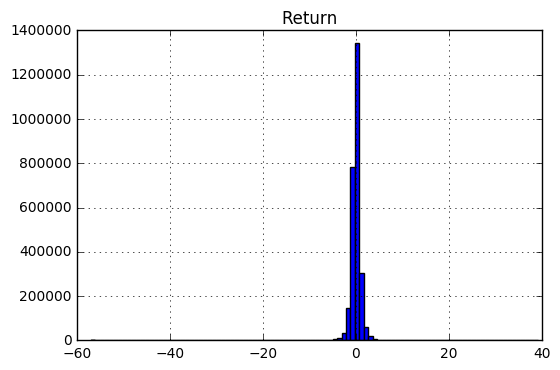

In [10]:
# first a quick look at the distribution of returns.
K.hist('Return',bins=100)

# now, where do we partition our classes?
q = K.Return.quantile([.333333,.666666]).values

print q

# let's add-in a 1-day Garman-Klass vol 
#K['GK'] = np.sqrt(np.abs( 252 * ( (1/2) * (np.log( K.High/ K.Low) )**2 - (2 *  np.log(2) - 1 ) * (np.log(K.Close/K.Open))**2 )))
K['SD'] = np.abs(K.SD)
#K['VOLARATIO'] = np.divide( K.GK , K.SD )

# let's classify date by doy and day of week
K['DOY'] = K.index.dayofyear
K['DOW'] = K.index.dayofweek

# let's encode the symbols
K['FSYM'], _ = pd.factorize(K.Sym)

# let's represent vol as ratio with ADV
K['VARATIO'] = np.abs(np.divide( K.Volume , K.ADV))

# let's create column of labels based on these values
K['Label'] = np.where( K.Fwd_Return <= q[0], 0, 
            np.where( K.Fwd_Return <= q[1], 1, 2))

# let's make sure labels look reasonable
print K.groupby('Label').size()

# Now that we have labels, let's get rid of fwd-looking values
K.drop(['Fwd_Return', 'Fwd_Close'],axis=1, inplace=True)

K.head()

In [11]:
# do we hava NaNs in our data?
K[K.isnull().any(axis=1)]


,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,SD,DOY,DOW,FSYM,VARATIO,Label
Date,,,,,,,,,,,,,,,


### now the data has been scaled and centered and we have both raw data (ie, prices, volume) and calculated data (ie, returns, sd, gk)

Let's partition into training and validation sets (80/20) and try a few different ways of packaging the data...

For training, we'll use three different data sets:
 - raw only
 - calculated only
 - raw & calculated

We'll try to use the tfcontrib code to ease our ascent of the tensorflow learning curve.


In [12]:
# we'll set our testing/validation divide 
TVDIVDATE = '2013-01-01'

# let's define which cols go where
RAW_COLS   = ['FSYM', 'Open','High','Low','DOY','DOW','Close','Volume']  #
CALCD_COLS = ['ADV', 'DeltaV', 'Return', 'SD',  'VARATIO' ]# 'GK', 'VOLARATIO',
RAWNCALCD_COLS = RAW_COLS + CALCD_COLS
SMRAW_COLS   = ['DOW','Close','Volume']  #
SRAWNCALCD_COLS = SMRAW_COLS + CALCD_COLS

Dataset = collections.namedtuple('Dataset', ['data', 'target'])

Ktrain = K[K.index<=TVDIVDATE].reset_index()
Kvlad = K[K.index>TVDIVDATE].reset_index()

# raw training/validations data sets
raw_train = Dataset(data=Ktrain[RAW_COLS],target=Ktrain.Label )
raw_vlad = Dataset(data=Kvlad[RAW_COLS],target=Kvlad.Label )

# calcd training/validations data sets
calcd_train = Dataset(data=Ktrain[CALCD_COLS],target=Ktrain.Label )
calcd_vlad = Dataset(data=Kvlad[CALCD_COLS],target=Kvlad.Label )

# raw+calcd training/validations data sets
rc_train = Dataset(data=Ktrain[RAWNCALCD_COLS],target=Ktrain.Label )
rc_vlad = Dataset(data=Kvlad[RAWNCALCD_COLS],target=Kvlad.Label )

# small raw training/validations data sets
smraw_train = Dataset(data=Ktrain[SMRAW_COLS],target=Ktrain.Label )
smraw_vlad = Dataset(data=Kvlad[SMRAW_COLS],target=Kvlad.Label )

# small raw+calcd training/validations data sets
src_train = Dataset(data=Ktrain[SRAWNCALCD_COLS],target=Ktrain.Label )
src_vlad = Dataset(data=Kvlad[SRAWNCALCD_COLS],target=Kvlad.Label )

print raw_train.data.tail()
print calcd_train.data.tail()
print rc_train.data.tail()
print src_train.data.tail()


         FSYM      Open      High       Low  DOY  DOW     Close    Volume
2102542   641 -0.953414 -0.970444 -0.956854  359    0 -0.960087 -0.675183
2102543   641 -0.955631 -0.970997 -0.945738  361    2 -0.968949 -0.105460
2102544   641 -0.966714 -0.987573 -0.960744  362    3 -0.968395  0.047643
2102545   641 -0.980013 -0.990335 -0.957410  363    4 -0.975595 -0.069338
2102546   641 -0.979459 -0.984257 -0.959077  366    0 -0.960641  0.016340
              ADV    DeltaV    Return        SD   VARATIO
2102542  0.465112 -4.333915 -0.122987  0.351849  1.451657
2102543  0.402229  2.564620 -0.250222  0.349234  0.262190
2102544  0.312341  0.372755  0.018703  0.485027  0.152535
2102545  0.293753 -0.279811 -0.204084  0.484436  0.236043
2102546  0.297725  0.207477  0.431168  0.480779  0.054882
         FSYM      Open      High       Low  DOY  DOW     Close    Volume       ADV    DeltaV    Return        SD   VARATIO
2102542   641 -0.953414 -0.970444 -0.956854  359    0 -0.960087 -0.675183  0.465112 

In [13]:
# let's store these datasets

forsims = { 'src_train': src_train,
            'src_vlad': src_vlad,
            'Kvlad': Kvlad }
fname = 'forsims.pkl'
pickle.dump(forsims, open( fname, "wb"))
log.info('Wrote %s', fname)

forsims = None

INFO:root:Wrote forsims.pkl


### data is partitioned into training/validation sets across four feature sets

let's define some functions to use the models from tensorflow


In [14]:

def _fitntestLinearClassifier( train, vlad, layers=None, model_dir='/tmp/model', steps=10 ):
    # use off-the-shelf Linear classifier, returning accuracy and responses
    fsize = len(train.data.columns)
    nclasses = len(train.target.unique())
    
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=fsize)]

    # Build model
    classifier = tf.contrib.learn.LinearClassifier(feature_columns=feature_columns,
                                                n_classes=nclasses,
                                                model_dir=model_dir)
    # Fit model.
    classifier.fit(x=train.data, y=train.target, steps=steps)

    # Evaluate accuracy.
    result = classifier.evaluate(x=vlad.data, y=vlad.target)
    
    print('Accuracy: {0:f}'.format(result["accuracy"]))
    return result,classifier

def _fitntestDNN( train, vlad, layers=None, model_dir='/tmp/model', steps=10 ):
    # build off-the-shelf network, train and validate
    fsize = len(train.data.columns)
    nclasses = len(train.target.unique())
    
    if layers is None:
        layers = [ fsize, fsize, fsize]
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=fsize)]

    # Build 3 layer DNN with fsize, 2*fsize, fsize layers
    classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                                hidden_units=layers,
                                                n_classes=nclasses,
                                                model_dir=model_dir)
    # Fit model.
    classifier.fit(x=train.data, y=train.target, steps=steps)

    # Evaluate accuracy.
    result = classifier.evaluate(x=vlad.data, y=vlad.target)
    
    print('Accuracy: {0:f}'.format(result["accuracy"]))
    return result,classifier

def _fitntestRandomForest( train, vlad, max_nodes=1024, steps=100, model_dir='/tmp/rf') :
    # build fit & test random forest for input
    fsize = len(train.data.columns)
    nclasses = len(train.target.unique())

    hparams = tf.contrib.tensor_forest.python.tensor_forest.ForestHParams(
        num_trees=nclasses, max_nodes=max_nodes, num_classes=nclasses, num_features=fsize)
    classifier = tf.contrib.learn.TensorForestEstimator(hparams)
    
    tdata = train.data.as_matrix().astype(np.float32)
    ttgt = train.target.as_matrix().astype(np.float32)
    vdata = vlad.data.as_matrix().astype(np.float32)
    vtgt = vlad.target.as_matrix().astype(np.float32)

    monitors = [tf.contrib.learn.TensorForestLossMonitor(10, 10)]
    classifier.fit(x=tdata, y=ttgt, steps=steps, monitors=monitors)
    result = classifier.evaluate(x=vdata, y=vtgt)#, steps=np.round(steps/10)

    print('Accuracy: {0:f}'.format(result["accuracy"]))
    return result,classifier



## Now let's train & test our model/featureset combinations

### first the linear classifier

In [15]:
steps = 10

# use the linear classifier 
raw_lc   = _fitntestLinearClassifier( train=raw_train, vlad=raw_vlad, model_dir='/tmp/raw_lc', steps=steps)
calcd_lc = _fitntestLinearClassifier( train=calcd_train, vlad=calcd_vlad, model_dir='/tmp/calcd_lc',steps=steps)
rc_lc    = _fitntestLinearClassifier( train=rc_train, vlad=rc_vlad, model_dir='/tmp/rc_lc', steps=steps)
smraw_lc   = _fitntestLinearClassifier( train=smraw_train, vlad=smraw_vlad, model_dir='/tmp/smraw_lc', steps=steps)
src_lc   = _fitntestLinearClassifier( train=src_train, vlad=src_vlad, model_dir='/tmp/src_lc', steps=steps)



Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.flo

Accuracy: 0.418572


INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.1343, step = 61
INFO:tensorflow:loss = 1.1343, step = 61
INFO:tensorflow:Saving checkpoints for 61 into /tmp/calcd_lc/model.ckpt.
INFO:tensorflow:Saving checkpoints for 61 into /tmp/calcd_lc/model.ckpt.
INFO:tensorflow:Saving checkpoints for 70 into /tmp/calcd_lc/model.ckpt.
INFO:tensorflow:Saving checkpoints for 70 into /tmp/calcd_lc/model.ckpt.
INFO:tensorflow:Loss for final step: 1.12529.
INFO:tensorflow:Loss for final step: 1.12529.
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=5, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=5, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Restored model from /tmp/calcd_lc
INFO:tensorflow:Restored model from /tmp/calcd_lc
INFO:tensorflow:Eval steps [0,inf) for training step 70.

Accuracy: 0.331047


INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(13)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(13)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=13, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=13, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 8.46654, step = 51
INFO:tensorflow:loss = 8.46654, step

Accuracy: 0.298263


INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=3, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=3, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.09075, step = 51
INFO:tensorflow:loss = 1.09075, step = 51
INFO:tensorflow:Saving checkpoints for 51 into /tmp/smraw_lc/model.ckpt.
INFO:tensorflow:Saving checkpoints for 51 into /tmp/smraw_lc/model.ckpt.
INFO:tensorflow:Saving checkpoints for 59 into /tmp/smraw_lc/model.ckpt.
INFO:tensorflow:Saving checkpoints for 59 into /tmp/smraw_lc/mode

Accuracy: 0.399397


INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=8, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=8, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.13785, step = 51
INFO:tensorflow:loss = 1.13785, step = 5

Accuracy: 0.392612


### deep neural network

In [16]:
# use the dnn
raw_dnn   = _fitntestDNN( train=raw_train, vlad=raw_vlad,model_dir='/tmp/raw_dnn', steps=steps)
calcd_dnn = _fitntestDNN( train=calcd_train, vlad=calcd_vlad,model_dir='/tmp/calcd_dnn', steps=steps)
rc_dnn    = _fitntestDNN( train=rc_train, vlad=rc_vlad,model_dir='/tmp/rc_dnn', steps=steps)
smraw_dnn   = _fitntestDNN( train=smraw_train, vlad=smraw_vlad,model_dir='/tmp/smraw_dnn', steps=steps)
src_dnn   = _fitntestDNN( train=src_train, vlad=src_vlad,model_dir='/tmp/src_dnn', steps=steps)

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.flo

Accuracy: 0.285690


INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.09135, step = 51
INFO:tensorflow:loss = 1.09135, step = 51
INFO:tensorflow:Saving checkpoints for 51 into /tmp/calcd_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 51 into /tmp/calcd_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 58 into /tmp/calcd_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 58 into /tmp/calcd_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /tmp/calcd_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /tmp/calcd_dnn/model.ckpt.
INFO:tensorflow:Loss for final step: 1.091.
INFO:tensorflow:Loss for final step: 1.091.
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=5, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=5, default_value=None, dtype=tf.float32, normalizer=None)
INFO:t

Accuracy: 0.296252


INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(13)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(13)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=13, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=13, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.09782, step = 51
INFO:tensorflow:loss = 1.09782, step

Accuracy: 0.296473


INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.09779, step = 51
INFO:tensorflow:loss = 1.09779, step = 51
INFO:tensorflow:Saving checkpoints for 51 into /tmp/smraw_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 51 into /tmp/smraw_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 59 into /tmp/smraw_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 59 into /tmp/smraw_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /tmp/smraw_dnn/model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /tmp/smraw_dnn/model.ckpt.
INFO:tensorflow:Loss for final step: 1.09721.
INFO:tensorflow:Loss for final step: 1.09721.
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=3, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=3, default_value=None, dtype=tf.float32, normalizer=None)
IN

Accuracy: 0.295692


INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float64, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.int64, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=8, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=8, default_value=None, dtype=tf.float32, normalizer=None)
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = 1.10861, step = 42
INFO:tensorflow:loss = 1.10861, step = 4

Accuracy: 0.296080


### random forests

In [17]:
# random forests
raw_rf   = _fitntestRandomForest(train=raw_train, vlad=raw_vlad, model_dir='/tmp/raw_rf', steps=steps)
calcd_rf   = _fitntestRandomForest(train=calcd_train, vlad=calcd_vlad, model_dir='/tmp/calcd_rf', steps=steps)
rc_rf   = _fitntestRandomForest(train=rc_train, vlad=rc_vlad, model_dir='/tmp/rc_rf', steps=steps)
smraw_rf   = _fitntestRandomForest(train=smraw_train, vlad=smraw_vlad, model_dir='/tmp/smraw_rf', steps=steps)
src_rf   = _fitntestRandomForest(train=src_train, vlad=src_vlad, model_dir='/tmp/src_rf', steps=steps)


INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimensio

Accuracy: 0.409617


INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:Create CheckpointSaverHook
INFO:tensorflow:loss = -0.0, step = 1
INFO:tensorflow:loss = -0.0, step = 1
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpHhyFRm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpHhyFRm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 10 into /tmp/tmpHhyFRm/model.ckpt.
INFO:tensorflow:Saving checkpoints for 10 into /tmp/tmpHhyFRm/model.ckpt.
INFO:tensorflow:Loss for final step: -30.0.
INFO:tensorflow:Loss for final step: -30.0.
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'valid_leaf_threshold': 1, 'split_after_samples': 250, 'num_output_columns': 4, 'feature_bagging_fraction': 1.0, 'split_initializations_per_input': 1, 'bagged_features': None, 'min_split_samples': 5, 'max_nodes': 1024, 'num_features': 5, 'num_trees': 3, 'num_splits_to_consider': 10, 'base_random_seed': 0, 'num_outputs': 1, 'max_fertile

Accuracy: 0.385247


INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(13)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(13)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'valid_leaf_threshold': 1, 'split_after_samples': 250, 'num_output_columns': 4, 'feature_bagging_fraction': 1.0, 'split_initializations_per_input': 1, 'bagged_features': None, 'min_split_samples': 5, 'max_nodes': 1024, 'num_features': 13, 'num_trees': 3, 'num_splits_to_consider': 10, 'base_random_seed': 0, 'num_outputs': 1, 'max_fert

Accuracy: 0.396138


INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(3)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(3)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'valid_leaf_threshold': 1, 'split_after_samples': 250, 'num_output_columns': 4, 'feature_bagging_fraction': 1.0, 'split_initializations_per_input': 1, 'bagged_features': None, 'min_split_samples': 5, 'max_nodes': 1024, 'num_features': 3, 'num_trees': 3, 'num_splits_to_consider': 10, 'base_random_seed': 0, 'num_outputs': 1, 'max_fertile

Accuracy: 0.390202


INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Setting targets info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None)]), is_sparse=False)
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'valid_leaf_threshold': 1, 'split_after_samples': 250, 'num_output_columns': 4, 'feature_bagging_fraction': 1.0, 'split_initializations_per_input': 1, 'bagged_features': None, 'min_split_samples': 5, 'max_nodes': 1024, 'num_features': 8, 'num_trees': 3, 'num_splits_to_consider': 10, 'base_random_seed': 0, 'num_outputs': 1, 'max_fertile

Accuracy: 0.399559


## let's aggregate & examine our results

In [18]:
# let's aggregate our results so far

results = pd.DataFrame( [ raw_lc[0],raw_dnn[0], calcd_lc[0], 
                         calcd_dnn[0], rc_lc[0], rc_dnn[0], smraw_lc[0],smraw_dnn[0],src_lc[0],src_dnn[0],
                        smraw_rf[0],calcd_rf[0],src_rf[0],raw_rf[0],rc_rf[0]])
results['model'] = ['Linear', 'DNN','Linear', 'DNN','Linear', 'DNN','Linear', 
                    'DNN','Linear', 'DNN','RandomForest','RandomForest','RandomForest','RandomForest','RandomForest']
results['features'] =['raw', 'raw','calcd','calcd','raw+calcd','raw+calcd','smraw',
                      'smraw','smraw+calcd','smraw+calcd','smraw','calcd','smraw+calcd','raw','raw+calcd']
results.sort_values('accuracy',inplace=True)
results


,accuracy,global_step,loss,model,features
1,0.285690,60,1.106627,DNN,raw
7,0.295692,60,1.110332,DNN,smraw
9,0.296080,51,1.125021,DNN,smraw+calcd
3,0.296252,60,1.105436,DNN,calcd
5,0.296473,60,1.111272,DNN,raw+calcd
4,0.298263,60,12.798348,Linear,raw+calcd
2,0.331047,70,1.139932,Linear,calcd
11,0.385247,10,NaN,RandomForest,calcd
10,0.390202,10,NaN,RandomForest,smraw
8,0.392612,60,1.125128,Linear,smraw+calcd


In [19]:
results.groupby('model').agg('median')

,accuracy,global_step,loss
model,,,
DNN,0.296080,60,1.110332
Linear,0.392612,60,1.139932
RandomForest,0.396138,10,NaN


In [20]:
results.groupby('features').agg('median').sort_values('accuracy')

,accuracy,global_step,loss
features,,,
raw+calcd,0.298263,60,6.954810
calcd,0.331047,60,1.122684
smraw,0.390202,60,1.098831
smraw+calcd,0.392612,51,1.125075
raw,0.409617,60,2.925446


                    model  accuracy
features                           
calcd                 DNN  0.296252
raw                   DNN  0.285690
raw+calcd             DNN  0.296473
smraw                 DNN  0.295692
smraw+calcd           DNN  0.296080
calcd              Linear  0.331047
raw                Linear  0.418572
raw+calcd          Linear  0.298263
smraw              Linear  0.399397
smraw+calcd        Linear  0.392612
calcd        RandomForest  0.385247
raw          RandomForest  0.409617
raw+calcd    RandomForest  0.396138
smraw        RandomForest  0.390202
smraw+calcd  RandomForest  0.399559


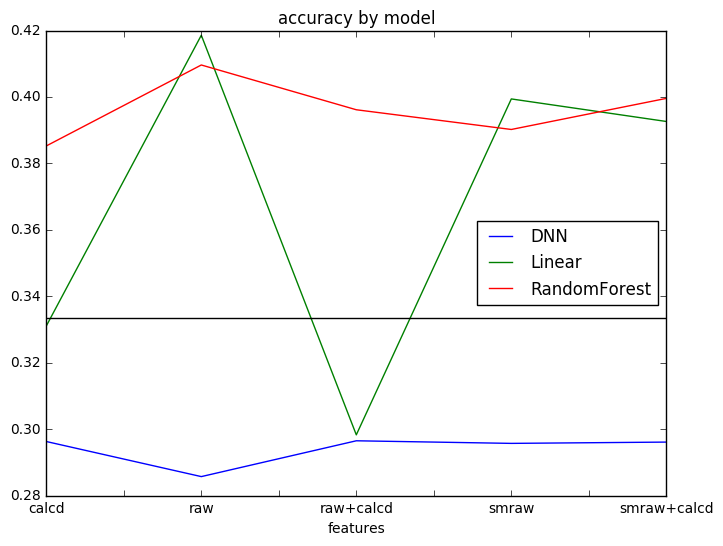

In [21]:

resdf = results[['model','features','accuracy']].sort_values(['model','features'])
resdf.set_index(resdf.features, inplace=True)
resdf.drop('features',axis=1,inplace=True)
print resdf
fig, ax = plt.subplots(figsize=(8,6))
for label, df in resdf.groupby('model'):
    df.accuracy.plot(ax=ax, label=label)
plt.axhline(y=.333333,color='black')
plt.legend(loc='center right')
plt.title('accuracy by model')


## Let's take a moment to consider our results so far.

### models

We've used three simple *off the shelf* models from tensorflow:
 - linear classifier (tf.contrib.learn.LinearClassifier)
 - DNN (tf.contrib.learn.DNNClassifier)
 - random forests (tf.contrib.learn.TensorForestEstimator)

We've gotten limited results as seen in the table ('accuracy by model') just above.  Basically, we expect a null-predictor to get a score of about 33.3% (the black line in the plot).  We were able to beat that in 10 of our 15 cases.  

The models matter.  The DNN severely underperformed with a median accuracy of 29.6% - nearly 4% worse than the null predictor.  Worse, it showed limited stability with four scores below par and then a wild 41% on the featureset that did worst for the other models.  It's very possible that the hyperparameters are poorly chosen, the model is undertrained or I'm misusing the model in some other fashion, but as implemented it doesn't perform.

The linear model does well but isn't terribly stable at least compared with the random forests which were both consistently positive and consistent across featuresets though clearly showing a preference for more data.

### featuresets

We've also created five different feature sets: 
 - raw (comprehensive) - all of our raw data (sym,dayofyear,dayofweek,open,high,low,close,volume)
 - smraw (small) - a subset of the raw data (dow, close, volume)
 - calculated - values calculated on raw data (ADV, DeltaV, Return, SD,  VARATIO)
 - raw+calculated - all data
 - smraw+calculated - small raw set with calculated set

It's likely that a limited amount of raw data and then well-chosen calculated data is best, but it's hard to make sweeping assessments based on this limited study.

Up until now, we've only looked at one day and one symbol in a featureset.  I'd like to look at stacking or enfolding the data so that we include several days of lookback values as inputs to the models.  Another variant of this would be to provide a consistently-sized universe of more than one symbol at a time, possibly also with a lookback element.


## Next steps for consideration

There remain numerous paths for progression.  Some of these:

 - Feature improvements.
     - More calculated features - create more calculated features for model training
     - Extend our featuresets by adding historical data
     - Extend our featuresets by looking at more than one name at a time
 - Different models and/or different hyperparameters.  
 - Drill-down a bit further on the results we've gotten so far
 - Complete the circuit: take our best results so far and see if we can integrate them into one of our existing strategies to see if such limited predictive ability might still yield meaningful results.
 
I like all these ideas and want to do them all.  But as practitioners, we press on to complete the circuit knowing that we can return to these studies with some concrete results in hand.

In the [next workbook](DEN3_sim.ipynb), we look at our simple strategies in a bit greater detail with pyfolio.

Following that, we'll complete the circuit and include predictive information from the random forest model to our strategies to see if/how they might be improved even with this limited edge.
 

## A brief look at the distance btw the average prediction and the actual followed by a brief look at random forest regression

In [22]:
vdata = src_vlad.data.as_matrix().astype(np.float32)
vtgt = src_vlad.target.as_matrix().astype(np.float32)

p=src_rf[1].predict( x=vdata)

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will cha

In [23]:
R = pd.DataFrame( {'predicted':p,'actual':vtgt})
R['dist'] = np.abs(R.actual-R.predicted)

# avg distance is meaningful.  a null predictor should get about .88, 
#  so anything below provides some edge
print R.dist.mean()
#R
twos=R.dist[R.dist==2]
len(twos.index)/float(len(R.index))
#len(twos)
#len(R.index)

0.723054230213


0.12261342162590515

## Does a random forests regression model outperform the classifier we've used?

In [24]:
# in the spirit of minimizing distance, let's see if we calculate 
#  distance from regression as that could be meaningful improvement

def _fitntestRandomForest_Regr( train, vlad, max_nodes=1024, steps=10, model_dir='/tmp/rfr') :
    # build fit & test random forest for input
    fsize = len(train.data.columns)
    nclasses = len(train.target.unique())

    hparams = tf.contrib.tensor_forest.python.tensor_forest.ForestHParams(
        num_trees=nclasses, max_nodes=max_nodes, num_classes=nclasses, num_features=fsize)
    classifier = tf.contrib.learn.TensorForestEstimator(hparams)
    
    tdata = train.data.as_matrix().astype(np.float32)
    ttgt = train.target.as_matrix().astype(np.float32)
    vdata = vlad.data.as_matrix().astype(np.float32)
    vtgt = vlad.target.as_matrix().astype(np.float32)

    regressor = tf.contrib.learn.TensorForestEstimator(hparams)
    monitors = [tf.contrib.learn.TensorForestLossMonitor(10, 10)]
    regressor.fit(x=tdata, y=ttgt, steps=steps, monitors=monitors)
    result = classifier.evaluate(x=vdata, y=vtgt)#, steps=np.round(steps/10)

    print('Accuracy: {0:f}'.format(result["accuracy"]))
    return result,classifier

src_rfr   = _fitntestRandomForest(train=src_train, vlad=src_vlad, model_dir='/tmp/src_rfr', steps=100)


INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(None), Dimension(8)]), is_sparse=False)
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.float32, shape=TensorShape([Dimensio

Accuracy: 0.408512


In [25]:

pr = src_rfr[1].predict( x=vdata)
RR = pd.DataFrame( {'predicted':pr,'actual':vtgt})
RR['dist'] = np.abs(RR.actual-RR.predicted)

# 
#  does regression beat the classifier for distance?
print RR.dist.mean()

twos=RR.dist[RR.dist==2]
print len(twos.index)/float(len(RR.index))



Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will cha

0.709970772266
0.118482728086


### interesting... doesn't seem to, but seems very close

we should probably set aside some time to consider trade-offs btw classification and regression approaches to these problems...
